In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
from model import make_envelope_1d, model1D, make_loss_fn,  power

In [3]:
M = 10
N = 2*M + 1
s = .5
phase_grad = .1 * 2 * np.pi 
lcl_phases = np.arange(-M, M+1) * phase_grad
lcl_patterns = [lambda theta: 1 for _ in range(N)]
weights = np.ones(N) / N


In [4]:
A = make_envelope_1d(s, lcl_phases, lcl_patterns, weights)

In [5]:
Nsamp = 1000
theta = np.linspace(-np.pi/2, np.pi/2, Nsamp)
amps = np.asarray([A(t) for t in theta])

In [6]:
P = np.abs(amps)**2

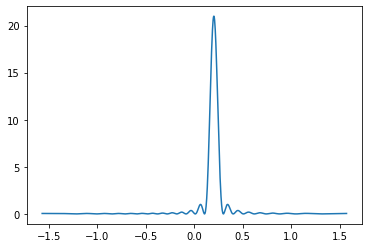

In [7]:
fig, ax = plt.subplots()
ax.plot(theta, P)

### Can you match a simple zero-deflection distribution?

In [8]:
#number of choices per element for each real-valued output
resolution = 128
#number of elements
M = 10
N = 2 * M + 1
# resolution at which power distribution is sampled
power_resolution = 100

In [9]:
model = model1D(power_resolution, N)

In [10]:
from torch.optim import SGD


In [11]:
lr = .005
steps = 10000
batch_size = 16

In [12]:
opt = SGD(model.parameters(), lr=lr)

In [13]:
losses = []
power_losses = []
powers = []
phases = []
wts = []

In [14]:
fixed_phases = np.zeros(N)
s = .5
lcl_patterns = [lambda t: 1 for _ in range(N)]
theta_vals = np.linspace(-np.pi/2, np.pi/2, power_resolution)
lossfn = make_loss_fn(s, fixed_phases, lcl_patterns, theta_vals)


In [15]:
phase_grad = 0.0 * 2 * np.pi 
lcl_phases = np.arange(-M, M+1) * phase_grad

env_target = make_envelope_1d(s, lcl_phases, lcl_patterns, np.ones(N)/N)
Ptarget = power(env_target, theta_vals)

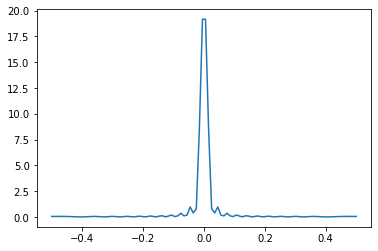

In [16]:
fig, ax =plt.subplots()
ax.plot(theta_vals/np.pi, Ptarget)

In [17]:
for i in range(steps):
    p = torch.tensor(Ptarget).to(dtype=torch.float).unsqueeze(0)
    # batch of input distributions
    inputs = p.expand(batch_size, power_resolution)
    phase_dist, wt_dist = model(inputs)
    phase_idx = phase_dist.sample()
    wt_idx = wt_dist.sample()
    
    phase_lp = phase_dist.log_prob(phase_idx).sum(dim=1)
    wt_lp = wt_dist.log_prob(wt_idx).sum(dim=1)
    
    #batch, N array of phases
    phase = 2 * np.pi * phase_idx.numpy() / resolution
    #batch, N array of relative weights
    wt = (wt_idx.to(dtype=torch.float) - resolution/2).softmax(1).numpy()

    # (batch,) tensor of power loss values.
    power_loss = torch.tensor(lossfn(phase, wt, Ptarget), dtype=torch.float)
    loss = (power_loss * (phase_lp + wt_lp)).mean()
    
    losses.append(loss.detach().item())
    
    model.zero_grad()
    loss.backward()
    opt.step()
    
    if i % 10 == 0:
        env = make_envelope_1d(s, fixed_phases + phase[-1, :], lcl_patterns, wt[-1, :])
        powers.append(power(env, theta_vals))
        phases.append(phase[-1, :])
        wts.append(wt[-1,:])
        power_losses.append(power_loss.mean().item())
    

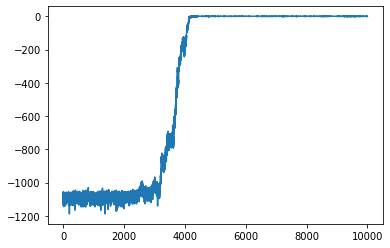

In [18]:
fig, ax = plt.subplots()
ax.plot(losses)

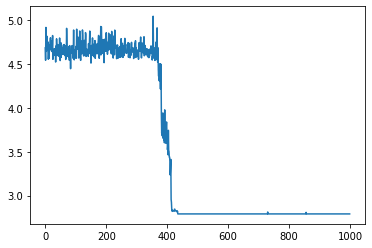

In [19]:
fig, ax = plt.subplots()
ax.plot(power_losses)

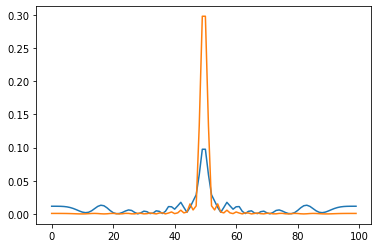

In [23]:
fig, ax = plt.subplots()
powersamp=powers[-1]
ax.plot(powersamp/np.sum(powersamp))
ax.plot(Ptarget)